In [28]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
from typing import List, Tuple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Looking at the effect of content embedding only on predicting win condition end state
Hypothesis - The MLP can use just the content embedding of winning moves to predict a winning '9' end state 

Result - WRONG BRO - not enough to make the prediction

Surprising result - Content embedding alone is enough for the MLP to assign low logits to the moves corresponding to those content embeddings. Content embeddings to the MLP is enough for the don't repeat move behavior. When attention output only is passed directly to the MLP, that is also enough for saying do not repeat move. Attention alone (without the rest of residual stream) is enough to predict a winning end state.

In [30]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)


In [9]:
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def get_content_embedding(seq: List) -> torch.Tensor:
    sequence = torch.tensor([seq])
    return model.embed(sequence)

def get_head_attention(seq: torch.Tensor) -> torch.Tensor:
    def hook(module, input, output):
        module.attention = output.clone()
    try:
        handle = model.blocks[0].hook_attn_out.register_forward_hook(hook)
        _ = model(seq)
        attention = model.blocks[0].hook_attn_out.attention
    except Exception as e:
        handle.remove()
        raise e
    
    return attention



In [10]:
winning_moves = [0,1,2]
content_embedding = get_content_embedding(winning_moves)
win_con_embedding = torch.sum(content_embedding[0], dim=0).view(1,1,128)
win_con_embedding.shape

torch.Size([1, 1, 128])

In [11]:
positional_seq = torch.tensor([10]*10).view(1,10)
pos_emb = model.pos_embed(positional_seq)
pos_emb_win = [pos_emb[0, i] for i in [1,3,5]]
pos_emb_win = torch.sum(torch.stack(pos_emb_win), dim=0).view(1,1,128)
pos_emb_win.shape

torch.Size([1, 1, 128])

In [12]:
win_embedding = win_con_embedding + pos_emb_win

In [13]:
logits_win_con = model.blocks[0].mlp(win_embedding) @ model.W_U
logits_win_con

/Users/omarayyub/p/Alphatoe/.venv/lib/python3.11/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


tensor([[[ -4.7482,  -3.0545,  -5.9183,   4.1520,   2.3924,   7.5088,   3.7037,
            6.1513,   7.5646, -14.8309]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)

In [14]:
fake_win = torch.tensor([10, 0, 10, 1, 10, 2])
logits = model(fake_win)
logits

tensor([[[  16.4406,   16.4415,   16.4427,   16.4385,   16.4421,   16.4415,
            16.4397,   16.4371,   16.4422, -117.7469],
         [ -73.5781,   13.6657,   13.6675,   13.6603,   13.6619,   13.6677,
            13.6644,   13.6623,   13.6662,  -41.8547],
         [ -28.0465,   19.5765,   14.9150,   16.1395,   14.9450,   16.9700,
            15.4190,   17.5065,   15.6091,  -87.9268],
         [ -30.0472,  -29.6935,   13.7019,   14.8522,   14.6196,   16.0425,
            13.7595,   14.6526,   15.0848,  -41.4792],
         [ -19.3795,  -10.7714,   14.2134,   15.0274,   14.2680,   15.9633,
            14.2001,   17.0041,   14.0319,  -64.8916],
         [ -33.0726,  -23.2774,  -34.1688,   10.0674,   10.0670,   10.6562,
             9.0185,   10.3589,   10.4061,   18.4578]]], device='mps:0',
       grad_fn=<AddBackward0>)

In [15]:
attention = get_head_attention(fake_win)
sliced = attention[0,-1]
sliced.shape

torch.Size([128])

In [16]:
stacked = torch.stack([sliced, win_con_embedding[0,0]])
stacked.shape

torch.Size([2, 128])

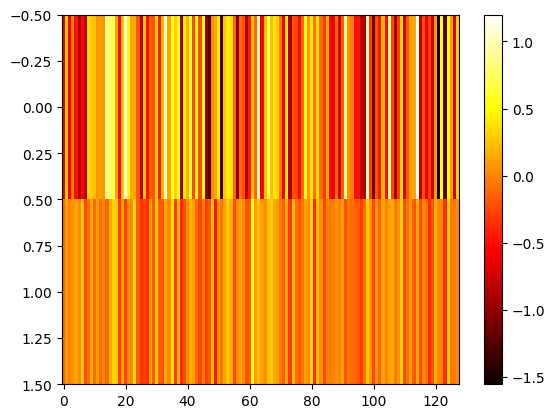

In [17]:
plt.imshow(stacked.detach().cpu(), cmap='hot', aspect='auto',interpolation='none')
plt.colorbar()

In [18]:
logits_attn = model.blocks[0].mlp(attention) @ model.W_U
logits_attn

tensor([[[ 13.2350,  12.3861,  12.3048,  13.7939,  14.1248,  14.4413,  11.7881,
           10.6163,  16.0264, -96.4960],
         [-64.7380,  11.2776,  12.2691,  13.5469,  14.5543,  11.4756,  11.1408,
           10.8533,  11.1956, -37.0330],
         [-30.3521,  14.0851,  11.9104,  15.7339,  15.0141,  13.4204,  11.8107,
           11.8507,  14.9609, -69.2896],
         [-32.3730, -22.5299,  10.4497,  13.5965,  13.2419,  10.8109,  11.0146,
           10.9845,  10.9871, -28.7890],
         [-22.2677, -15.6074,  10.3264,  14.3509,  13.1118,  11.0505,  10.2053,
           11.2858,  11.8497, -41.8312],
         [-33.9930, -25.0382, -25.0736,   9.9151,  10.0481,   6.3351,   6.9709,
            8.4722,   7.8148,  21.1565]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)

In [19]:
attention_minus_content = attention[0,-1] - win_con_embedding[0,0]
attention_minus_content = attention_minus_content.view(1,1,128)

In [20]:
logits_attn_minus_content = model.blocks[0].mlp(attention_minus_content) @ model.W_U
logits_attn_minus_content

tensor([[[-27.3886, -19.0932, -17.6540,   7.4534,   8.3427,   0.2983,   5.0659,
            6.5888,   3.4145,  19.5694]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)